In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# load data
course_genre_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_genre.csv"
ratings_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-ML0321EN-Coursera/labs/v2/module_3/ratings.csv"

course_df = pd.read_csv(course_genre_url)
ratings_df = pd.read_csv(ratings_url)

### Data Preparation

In [7]:
def process_dataset(raw_data):
    """
        Preprocesses the raw dataset by encoding user and item IDs to indices.

        Args:
        - raw_data (DataFrame): Raw dataset containing user, item, and rating information.

        Returns:
        - encoded_data (DataFrame): Processed dataset with user and item IDs encoded as indices.
        - user_idx2id_dict (dict): Dictionary mapping user indices to original user IDs.
        - course_idx2id_dict (dict): Dictionary mapping item indices to original item IDs.
    """

    encoded_data = raw_data.copy() # Make a copy of the raw dataset to avoid modifying the original data.

    # Mapping user ids to indices
    user_list = encoded_data["user"].unique().tolist() # Get unique user IDs from the dataset.
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)} # Create a dictionary mapping user IDs to indices.
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)} # Create a dictionary mapping user indices back to original user IDs.

    # Mapping course ids to indices
    course_list = encoded_data["item"].unique().tolist() # Get unique item (course) IDs from the dataset.
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)} # Create a dictionary mapping item IDs to indices.
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)} # Create a dictionary mapping item indices back to original item IDs.

    # Convert original user ids to idx
    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)
    # Convert original course ids to idx
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)
    # Convert rating to int
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")

    return encoded_data, user_idx2id_dict, course_idx2id_dict # Return the processed dataset and dictionaries mapping indices to original IDs.


def generate_train_test_datasets(dataset, scale=True):
    """
        Splits the dataset into training, validation, and testing sets.

        Args:
        - dataset (DataFrame): Dataset containing user, item, and rating information.
        - scale (bool): Indicates whether to scale the ratings between 0 and 1. Default is True.

       Returns:
        - x_train (array): Features for training set.
        - x_val (array): Features for validation set.
        - x_test (array): Features for testing set.
        - y_train (array): Labels for training set.
        - y_val (array): Labels for validation set.
        - y_test (array): Labels for testing set.
    """

    min_rating = min(dataset["rating"]) # Get the minimum rating from the dataset
    max_rating = max(dataset["rating"]) # Get the maximum rating from the dataset

    dataset = dataset.sample(frac=1, random_state=42) # Shuffle the dataset to ensure randomness
    x = dataset[["user", "item"]].values # Extract features (user and item indices) from the dataset
    if scale:
        # Scale the ratings between 0 and 1 if scale=True
        y = dataset["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        # Otherwise, use raw ratings
        y = dataset["rating"].values

    # Assuming training on 80% of the data and testing on 10% of the data
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])
    # Assigning subsets of features and labels for each set
    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices], # Training features
        x[train_indices:test_indices], # Validation features
        x[test_indices:], # Testing features
        y[:train_indices], # Training labels
        y[train_indices:test_indices], # Validation labels
        y[test_indices:], # Testing labels
    )
    return x_train, x_val, x_test, y_train, y_val, y_test # Return the training, validation, and testing sets

In [6]:
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(ratings_df)

In [8]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)

In [9]:
user_indices = x_train[:, 0]
user_indices

array([ 8376,  7659, 10717, ...,  3409, 28761,  4973])

In [10]:
item_indices = x_train[:, 1]
item_indices

array([12, 29,  3, ..., 18, 19, 17])

In [11]:
y_train

array([0., 0., 0., ..., 0., 1., 0.])

### Neural Network Class

In [17]:
class RecommenderNet(keras.Model):
    """
        Neural network model for recommendation.

        This model learns embeddings for users and items, and computes the dot product
        of the user and item embeddings to predict ratings or preferences.

        Attributes:
        - num_users (int): Number of users.
        - num_items (int): Number of items.
        - embedding_size (int): Size of embedding vectors for users and items.
    """
    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
            Constructor.

            Args:
            - num_users (int): Number of users.
            - num_items (int): Number of items.
            - embedding_size (int): Size of embedding vectors for users and items.
         """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        # A name for the layer, which helps in identifying the layer within the model.

        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        # Bias is applied per user, hence output_dim is set to 1.
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")

        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        # Bias is applied per item, hence output_dim is set to 1.
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")

    def call(self, inputs):
        """
            Method called during model fitting.

            Args:
            - inputs (tf.Tensor): Input tensor containing user and item one-hot vectors.

            Returns:
            - tf.Tensor: Output tensor containing predictions.
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        # Compute the user bias
        user_bias = self.user_bias(inputs[:, 0])
        # Compute the item embedding vector
        item_vector = self.item_embedding_layer(inputs[:, 1])
        # Compute the item bias
        item_bias = self.item_bias(inputs[:, 1])
         # Compute dot product of user and item embeddings
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Apply ReLU activation function
        return tf.nn.relu(x)

#### Execution

In [20]:
num_users = len(ratings_df['user'].unique())
num_items = len(ratings_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


In [21]:
embedding_size = 16
model = RecommenderNet(num_users, num_items, embedding_size)

Epoch 1/10
2917/2917 [==============================] - 27s 9ms/step - loss: 0.1952 - root_mean_squared_error: 0.4414 - val_loss: 0.1802 - val_root_mean_squared_error: 0.4238
Epoch 2/10
2917/2917 [==============================] - 29s 10ms/step - loss: 0.1707 - root_mean_squared_error: 0.4122 - val_loss: 0.1784 - val_root_mean_squared_error: 0.4214
Epoch 3/10
2917/2917 [==============================] - 29s 10ms/step - loss: 0.1615 - root_mean_squared_error: 0.4005 - val_loss: 0.1796 - val_root_mean_squared_error: 0.4223
Epoch 4/10
2917/2917 [==============================] - 29s 10ms/step - loss: 0.1569 - root_mean_squared_error: 0.3944 - val_loss: 0.1827 - val_root_mean_squared_error: 0.4256
Epoch 5/10
2917/2917 [==============================] - 27s 9ms/step - loss: 0.1547 - root_mean_squared_error: 0.3911 - val_loss: 0.1878 - val_root_mean_squared_error: 0.4312
Epoch 6/10
2917/2917 [==============================] - 21s 7ms/step - loss: 0.1536 - root_mean_squared_error: 0.3892 - va

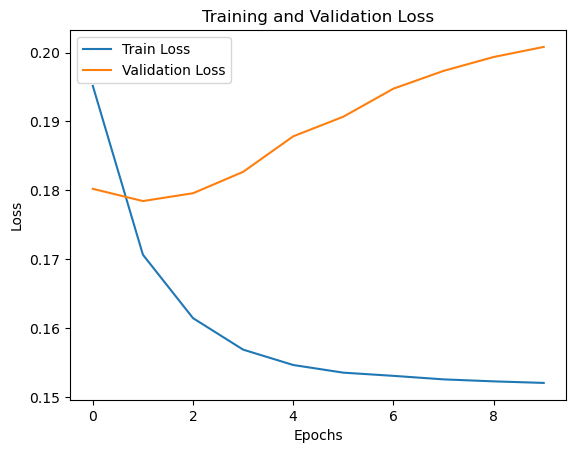

In [22]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

 
## - call model.fit() to train the model
# Train the model
history = model.fit(
    x=x_train, 
    y=y_train, 
    batch_size=64, 
    epochs=10, 
    validation_data=(x_val, y_val),
    verbose=1
)


#  - -Save the entire model in the SavedModel format and then save only the weights of the model using 

## - - model.save_weights("recommender_net_weights.weights.h5")
# Save model weights
model.save_weights("recommender_net_weights.weights.h5")

 
## - plot the train and validation loss

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
model.evaluate(x_test, y_test)

## Second (Improved?) Neural Network

#### Including non-linear layers

In [33]:
class ImprovedRecommenderNet(keras.Model):
    """
    Improved Neural Network Model for Recommendations.

    This model learns embeddings for users and items and uses a neural network 
    to predict ratings or preferences.
    """
    def __init__(self, num_users, num_items, embedding_size=32, dropout_rate=0.3, **kwargs):
        super(ImprovedRecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        # User embedding layer
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        # Item embedding layer
        self.item_embedding = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.item_bias = layers.Embedding(num_items, 1)

        # Fully connected layers for deeper feature extraction
        self.dense1 = layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.batch_norm1 = layers.BatchNormalization()
        self.dropout1 = layers.Dropout(dropout_rate)

        self.dense2 = layers.Dense(32, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.batch_norm2 = layers.BatchNormalization()
        self.dropout2 = layers.Dropout(dropout_rate)

        self.dense3 = layers.Dense(16, activation="relu")
        
        # Output layer with sigmoid activation to predict scores in range [0, 1]
        self.output_layer = layers.Dense(1, activation="sigmoid")

    def call(self, inputs):
        user_input, item_input = inputs[:, 0], inputs[:, 1]

        # Compute embeddings
        user_vector = self.user_embedding(user_input)
        item_vector = self.item_embedding(item_input)

        # Compute biases
        user_bias = self.user_bias(user_input)
        item_bias = self.item_bias(item_input)

        # Concatenate user and item vectors instead of just dot product
        x = layers.Concatenate()([user_vector, item_vector])

        # Pass through dense layers
        x = self.dense1(x)
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        x = self.dense2(x)
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        x = self.dense3(x)

        # Add biases
        x = x + user_bias + item_bias

        # Predict final score
        return self.output_layer(x)


In [34]:

embedding_size = 16  # Increased from 16 for better feature representation

# Instantiate the improved model
model = ImprovedRecommenderNet(num_users, num_items, embedding_size)

# Compile
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)


In [35]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

Epoch 1/20
2917/2917 [==============================] - 31s 10ms/step - loss: 0.2133 - root_mean_squared_error: 0.4110 - val_loss: 0.1665 - val_root_mean_squared_error: 0.4076
Epoch 2/20
2917/2917 [==============================] - 26s 9ms/step - loss: 0.1663 - root_mean_squared_error: 0.4075 - val_loss: 0.1665 - val_root_mean_squared_error: 0.4079
Epoch 3/20
2917/2917 [==============================] - 24s 8ms/step - loss: 0.1586 - root_mean_squared_error: 0.3981 - val_loss: 0.1716 - val_root_mean_squared_error: 0.4142
Epoch 4/20
2917/2917 [==============================] - 29s 10ms/step - loss: 0.1531 - root_mean_squared_error: 0.3911 - val_loss: 0.1754 - val_root_mean_squared_error: 0.4188
Epoch 5/20
2917/2917 [==============================] - 30s 10ms/step - loss: 0.1504 - root_mean_squared_error: 0.3878 - val_loss: 0.1781 - val_root_mean_squared_error: 0.4220


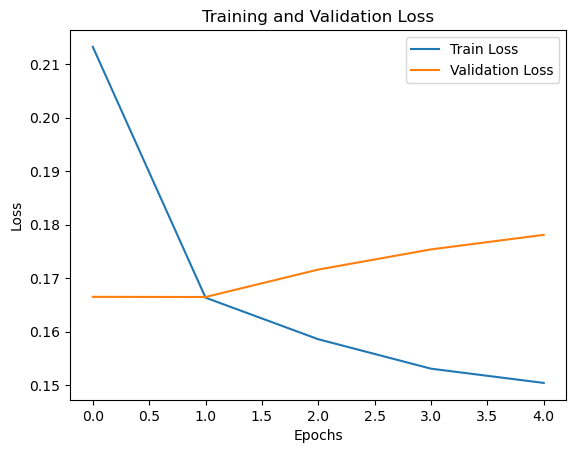

In [36]:
# Train the model
history = model.fit(
    x=x_train, 
    y=y_train, 
    batch_size=64, 
    epochs=20, 
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Save weights
model.save_weights("improved_recommender_net_weights.h5")


# Plot loss curves
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [37]:
model.evaluate(x_test, y_test)

730/730 [==============================] - 2s 3ms/step - loss: 0.1660 - root_mean_squared_error: 0.4073


[0.1659812331199646, 0.40732866525650024]

#### Both Models are overfitting... :/

## Visualize the results from all 3 notebooks

In [41]:
scores_data = {
    "Model": [
        "KNN Basic", 
        "KNN Basic (HPO)", 
        "KNNWithMeans", 
        "KNNWithMeans (HPO)", 
        "KNNWithZScore", 
        "KNNWithZScore (HPO)", 
        "NMF", 
        "NMF (Tuned)", 
        "NeuralNetwork 1", 
        "NeuralNetwork 2"
    ],
    "RMSE": [
        1.289004556469686, 
        1.2895089797022696, 
        1.289069413254954, 
        1.289518312542621, 
        1.2890, 
        1.2895457396152161, 
        1.2899024294405703, 
        1.2915458330737486, 
        0.4413, 
        0.4840
    ]
}

scores = pd.DataFrame(scores_data)

scores = scores.sort_values(by='RMSE', ascending=True)
scores

,Model,RMSE
8,NeuralNetwork 1,0.441300
9,NeuralNetwork 2,0.484000
4,KNNWithZScore,1.289000
0,KNN Basic,1.289005
2,KNNWithMeans,1.289069
1,KNN Basic (HPO),1.289509
3,KNNWithMeans (HPO),1.289518
5,KNNWithZScore (HPO),1.289546
6,NMF,1.289902
7,NMF (Tuned),1.291546


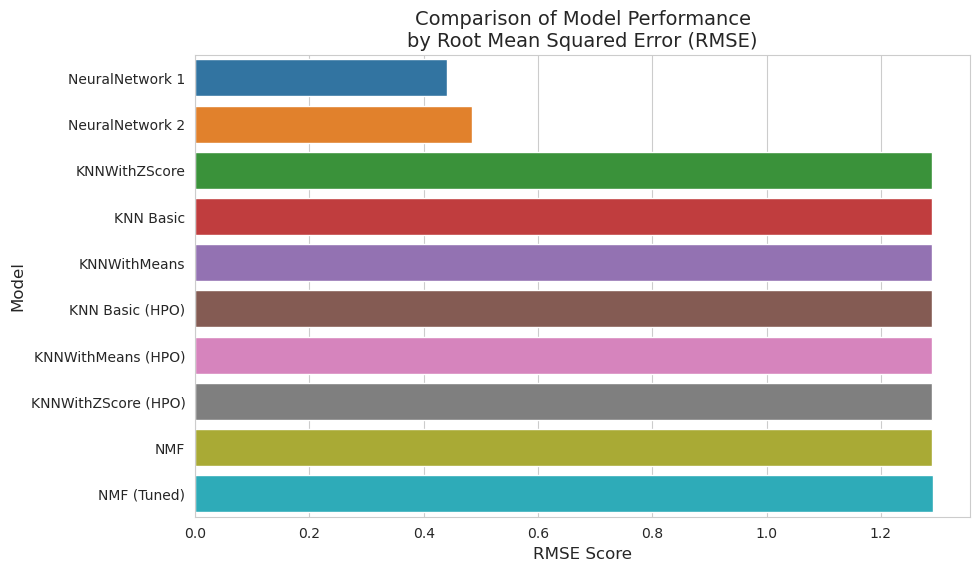

In [43]:
# Set the style
sns.set_style("whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x="RMSE", y="Model", data=scores, palette="tab10"
)

# Add titles and labels
plt.xlabel("RMSE Score", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.title("Comparison of Model Performance\nby Root Mean Squared Error (RMSE)", fontsize=14)

# Display the plot
plt.show()